In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- SETUP DA SIMULAÇÃO ---
np.random.seed(123)
n_samples = 3000

# 1. Sistema Desconhecido (Planta IIR)
# H(z) = (0.2 + 0.5z^-1) / (1 - 1.2z^-1 + 0.5z^-2)
# Planta com polos complexos para testar a robustez do algoritmo
b_true = np.array([0.2, 0.5])
a_true_vals = np.array([1.2, -0.5]) # Em w: [-a1, -a2] -> [1.2, -0.5]

zeros_order = len(b_true) - 1
poles_order = len(a_true_vals)

# 2. Geração de Sinais
x = np.random.randn(n_samples) 
# d[k] com ruído branco aditivo
d_clean = signal.lfilter(b_true, np.insert(-a_true_vals, 0, 1.0), x)
d = d_clean + 0.1 * np.random.randn(n_samples) # SNR razoável para teste

In [3]:
# --- INICIALIZAÇÃO DO FILTRO ---
# O step_size no SM atua no "erro auxiliar" filtrado.
sm_filter = pdf.SteiglitzMcBride(
    zeros_order=zeros_order,
    poles_order=poles_order,
    step_size=0.002
)

# --- EXECUÇÃO ---
result = sm_filter.optimize(
    input_signal=x, 
    desired_signal=d, 
    verbose=True, 
    return_internal_states=True
)

[SteiglitzMcBride] Completed in 76.50 ms


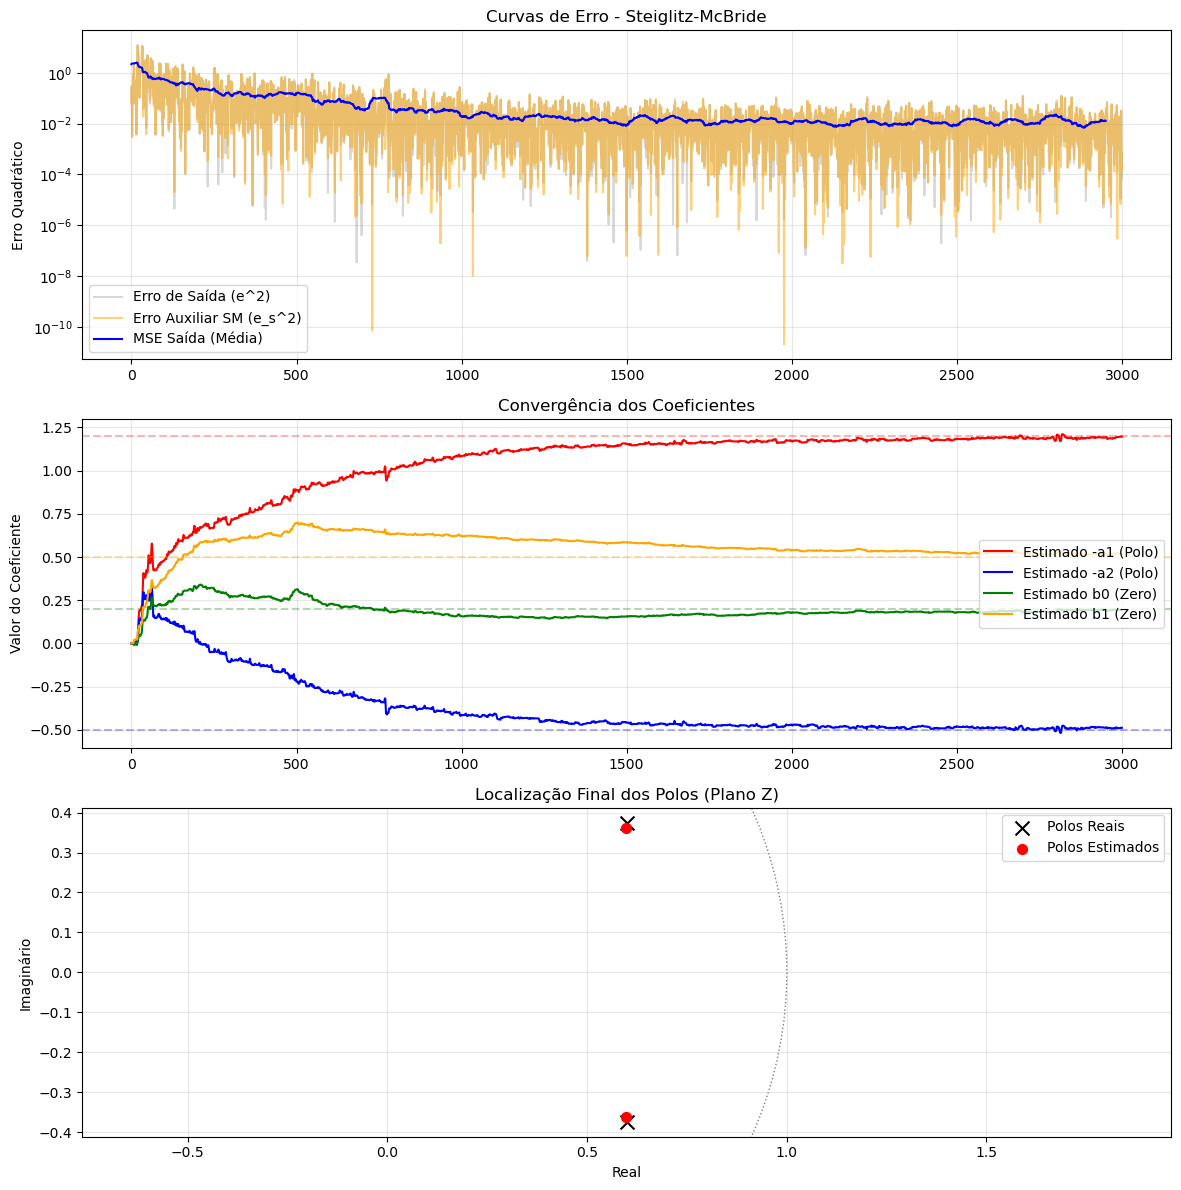

Coeficientes Reais: [ 1.2 -0.5  0.2  0.5]
Coeficientes Finais SM: [ 1.19605619 -0.48802039  0.19175136  0.51851697]


In [4]:
# --- VISUALIZAÇÃO ---
plt.figure(figsize=(12, 12))

# 1. Erro de Saída vs Erro Auxiliar (SM)
plt.subplot(3, 1, 1)
plt.semilogy(result.errors**2, label='Erro de Saída (e^2)', alpha=0.3, color='gray')
plt.semilogy(result.extra["auxiliary_error"]**2, label='Erro Auxiliar SM (e_s^2)', alpha=0.5, color='orange')
# Média móvel para clareza
plt.semilogy(np.convolve(result.errors**2, np.ones(50)/50, mode='valid'), label='MSE Saída (Média)', color='blue')
plt.title('Curvas de Erro - Steiglitz-McBride')
plt.ylabel('Erro Quadrático')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# 2. Evolução dos Pesos
plt.subplot(3, 1, 2)
w_hist = np.array(result.coefficients)
colors = ['red', 'blue', 'green', 'orange']
labels = ['-a1 (Polo)', '-a2 (Polo)', 'b0 (Zero)', 'b1 (Zero)']

for i in range(sm_filter.n_coeffs):
    plt.plot(w_hist[:, i], label=f'Estimado {labels[i]}', color=colors[i])
    # Referências reais
    ref = a_true_vals[i] if i < poles_order else b_true[i - poles_order]
    plt.axhline(y=ref, color=colors[i], linestyle='--', alpha=0.3)

plt.title('Convergência dos Coeficientes')
plt.ylabel('Valor do Coeficiente')
plt.legend(loc='center right')
plt.grid(True, alpha=0.3)

# 3. Verificação de Estabilidade (Z-Plane dos Polos Finais)
plt.subplot(3, 1, 3)
w_final = sm_filter.w
a_est = w_final[:poles_order]
# Polos: raízes de 1 - a1*z^-1 - a2*z^-2 = 0  => z^2 - a1*z - a2 = 0
poles_est = np.roots(np.insert(-a_est, 0, 1.0))
poles_true = np.roots(np.insert(-a_true_vals, 0, 1.0))

unit_circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle=':', alpha=0.5)
plt.gca().add_artist(unit_circle)
plt.scatter(poles_true.real, poles_true.imag, marker='x', s=100, color='black', label='Polos Reais')
plt.scatter(poles_est.real, poles_est.imag, marker='o', s=50, color='red', label='Polos Estimados')
plt.title('Localização Final dos Polos (Plano Z)')
plt.xlabel('Real')
plt.ylabel('Imaginário')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Coeficientes Reais: {np.concatenate((a_true_vals, b_true))}")
print(f"Coeficientes Finais SM: {sm_filter.w}")